In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW

In [2]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    # Ny, Nx = size(B)
    return ifftshift(ifft(ifftshift(B)))
end

Diff_Image(image, c=0.1) = @. log1p(c*abs(image))

Diff_Image (generic function with 2 methods)

In [3]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511.0 #keV
    return hc/sqrt(abs(E*(2*E₀ + E)))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

In [4]:
function BarFunction(modes::Vector{<:Integer}, amk::AbstractVector) 

    len_x::eltype(modes) = length(amk)
    m_min::eltype(modes) = minimum(modes)
    m_max::eltype(modes) = maximum(modes)
    # shifted_amk = fftshift(amk)
    shifted_amk = amk
    

    idx = div(len_x, 2) + 1
    if m_min >= 0
        idx_vec = idx-1:(idx+m_max+1)
    elseif m_max <=0
        idx_vec = (idx+m_min-1):idx+1
    else
        idx_vec = (idx+m_min-1):(idx+m_max+1)
    end

    Energy = sum(shifted_amk[modes.+idx].^2)
    kolor=rand([:red, :blue, :green, :yellow, :orange, :pink, :cyan, :magenta, :brown, :black])
    xtick_labels = idx_vec .- idx
    fig = bar(idx_vec, shifted_amk[idx_vec].^2, legend=false, color=kolor, title="Fourier Coefficients, |aₖ|², of φ(x)", ylabel=L"|a_k|^2", xticks=(idx_vec, xtick_labels))
    return fig, Energy
end

BarFunction (generic function with 1 method)

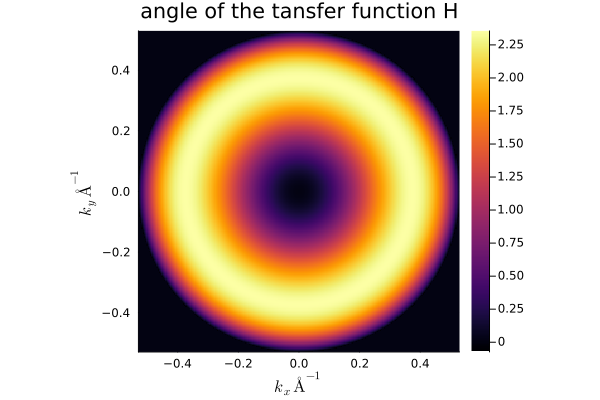

In [5]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms
λ_const = Wavelength(E)

N = 2^8
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = collect(range(-L/2, L/2, N))
y = collect(range(-L/2, L/2, N))


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
# H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
H = @. exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

\begin{align}
    e^{i\tilde{k}_z z} &= e^{i\frac{w}{c}(n+i\kappa)z}\\
    &= e^{-\frac{2\pi}{\lambda}\kappa z}e^{i\frac{2\pi}{\lambda}n z}
\end{align}

\begin{equation}
\psi_z(z) = \exp(ik_z(0)z)\exp(i\sigma U_{mip}z)
\end{equation}



\begin{equation}
    \int_0^{t_0} dz\, \sigma U_{mip} = \sigma U_{mip}\, t_0 = \Phi t_0
\end{equation}

\begin{equation}
    \tilde{\Phi} = \sigma U_{mip} + i\alpha
\end{equation}


\begin{align}
    \sigma U_{mip} &\approx 0.15\,\text{rad}\cdot\text{nm}^{-1}\\
    \alpha &\approx 0.008\,\text{nm}^{-1}
\end{align}

In [6]:
"""
lets estimate n and κ from CjW thesis. Lets assume there is a 10 phase_reconstruced
decay and pi/2 phase shift after 50nm
"""
λ_nm = Wavelength(E)/10 # convert to nm
#given
σU = 0.15 
α = 0.008 
distance_est = 50 #nm
κ = α * (λ_nm/(2*π)) # this is the attenuation coefficient 

2.5066020800003746e-6

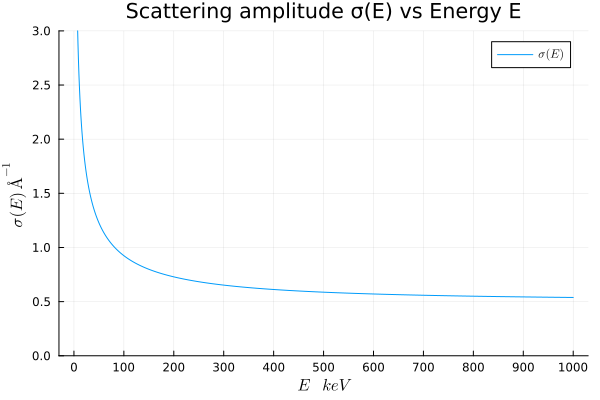

In [7]:
Es = range(0, 1000, length=1000) # energy range from 0 to 1000 keV
σ(E) = 2π/(Wavelength(E)*E) * (511 + E)/(2*511 + E)
plot(Es, σ.(Es), label=L"σ(E)", xlabel=L"E\quad keV", ylabel=L"σ(E)\, \AA^{-1}", 
    title="Scattering amplitude σ(E) vs Energy E", legend=:topright,
    xticks=0:100:1000, yticks=0.0:0.5:3.0)
ylims!(0, 3.0)

In [8]:
σ_cjw = σ(300) * 10 # per nm 
U_mip = σU/σ_cjw 


0.022983624805675437

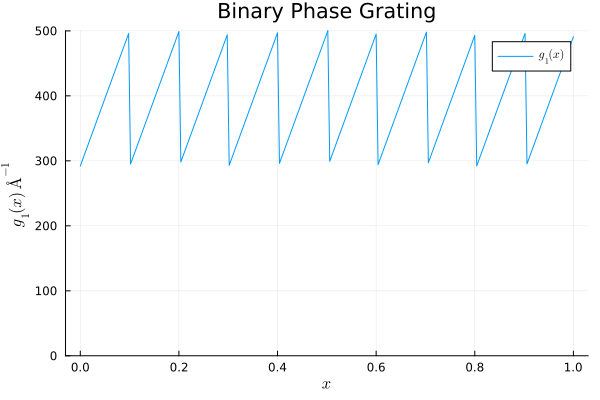

In [9]:
xs = range(0, 1, length=N)
thickness = 500 #Angstroms
mill_depth = 208 #Angstroms
d0 = thickness - mill_depth
g1(p) = @. mod(p*mill_depth*xs, mill_depth+1) + d0
plot(xs, g1(10), label=L"g_1(x)", xlabel=L"x", ylabel=L"g_1(x)\, \AA^{-1}", 
    title="Binary Phase Grating", legend=:topright,
    xticks=0:0.2:1, yticks=0:100:500)
ylims!(0, 500)

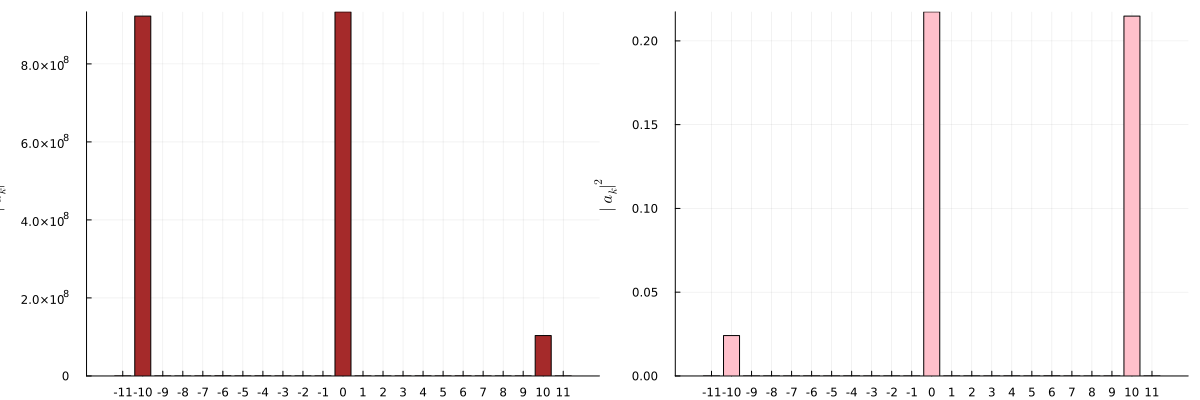

In [ ]:

ψ_grating = @. cis((σ(E)*U_mip+1im*κ*2π/Wavelength(E))*$g1(10));
ψ_grating2d = repeat(ψ_grating', N, 1)
modes = collect(-10:1:10)
fig1, = BarFunction(modes, abs.(fftnshift(ψ_grating2d))[N÷2+1, :])
fig2,  = BarFunction(modes, abs.(ifftnshift(ψ_grating2d.*H))[N÷2+1, :]) 

plot(fig1, fig2, layout=(1, 2), size=(1200, 400), 
    title="")
# heatmap(abs2.(fftnshift(ψ_grating2d.*H)), aspect_ratio=:equal,
#         title="Intensity of the transfer function H", 
#         xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}")
# xlims!(xs[40], xs[60])

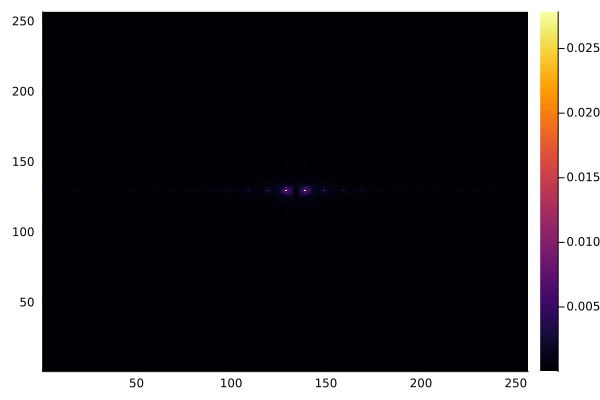

In [12]:
heatmap(Diff_Image(ifftnshift(ψ_grating2d.*H), 0.1))